In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [28]:
# Load data
df = pd.read_csv('dialogs.txt', sep='\t', names=['question', 'answer'])
print(f'Dataframe size: {len(df)}')
df.head()

Dataframe size: 3725


,question,answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


## Data Preprocessing

In [31]:
df['question tokens']=df['question'].apply(lambda x:len(x.split()))
df['answer tokens']=df['answer'].apply(lambda x:len(x.split()))

In [32]:
def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

df.drop(columns=['answer tokens','question tokens'],axis=1,inplace=True)
df['encoder_inputs']=df['question'].apply(clean_text)
df['decoder_targets']=df['answer'].apply(clean_text)+' <end>'
df['decoder_inputs']='<start> '+df['answer'].apply(clean_text)+' <end>'

df.head(10)

,question,answer,encoder_inputs,decoder_targets,decoder_inputs
0,"hi, how are you doing?",i'm fine. how about yourself?,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem. so how have you been?,i've been great. what about you?,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i've been great. what about you?,i've been good. i'm in school right now.,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i've been good. i'm in school right now.,what school do you go to?,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to?,i go to pcc.,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc.,do you like it there?,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there?,it's okay. it's a really big campus.,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it's okay. it's a really big campus.,good luck with school.,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


In [33]:
df['encoder input tokens']=df['encoder_inputs'].apply(lambda x:len(x.split()))
df['decoder input tokens']=df['decoder_inputs'].apply(lambda x:len(x.split()))
df['decoder target tokens']=df['decoder_targets'].apply(lambda x:len(x.split()))

In [34]:
print(f"After preprocessing: {' '.join(df[df['encoder input tokens'].max()==df['encoder input tokens']]['encoder_inputs'].values.tolist())}")
print(f"Max encoder input length: {df['encoder input tokens'].max()}")
print(f"Max decoder input length: {df['decoder input tokens'].max()}")
print(f"Max decoder target length: {df['decoder target tokens'].max()}")

df.drop(columns=['question','answer','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":2500,
    "max_sequence_length":30,
    "learning_rate":0.008,
    "batch_size":149,
    "lstm_cells":256,
    "embedding_dim":256,
    "buffer_size":10000
}
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
df.head(10)

After preprocessing: for example ,  if your birth date is january  1  2  ,   1  9  8  7  ,  write  0  1  /  1  2  /  8  7  . 
Max encoder input length: 27
Max decoder input length: 29
Max decoder target length: 28


,encoder_inputs,decoder_targets,decoder_inputs
0,"hi , how are you doing ?",i ' m fine . how about yourself ? <end>,<start> i ' m fine . how about yourself ? <end>
1,i ' m fine . how about yourself ?,i ' m pretty good . thanks for asking . <end>,<start> i ' m pretty good . thanks for asking...
2,i ' m pretty good . thanks for asking .,no problem . so how have you been ? <end>,<start> no problem . so how have you been ? ...
3,no problem . so how have you been ?,i ' ve been great . what about you ? <end>,<start> i ' ve been great . what about you ? ...
4,i ' ve been great . what about you ?,i ' ve been good . i ' m in school right now ...,<start> i ' ve been good . i ' m in school ri...
5,i ' ve been good . i ' m in school right now .,what school do you go to ? <end>,<start> what school do you go to ? <end>
6,what school do you go to ?,i go to pcc . <end>,<start> i go to pcc . <end>
7,i go to pcc .,do you like it there ? <end>,<start> do you like it there ? <end>
8,do you like it there ?,it ' s okay . it ' s a really big campus . <...,<start> it ' s okay . it ' s a really big cam...
9,it ' s okay . it ' s a really big campus .,good luck with school . <end>,<start> good luck with school . <end>


### Tokenization

In [35]:
vectorize_layer=TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(df['encoder_inputs']+' '+df['decoder_targets']+' <start> <end>')
vocab_size=len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {len(vectorize_layer.get_vocabulary())}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 2443
['', '[UNK]', '<end>', '.', '<start>', "'", 'i', '?', 'you', ',', 'the', 'to']


In [36]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x=sequences2ids(df['encoder_inputs'])
yd=sequences2ids(df['decoder_inputs'])
y=sequences2ids(df['decoder_targets'])

print(f'Question sentence: hi , how are you ?')
print(f'Question to tokens: {sequences2ids("hi , how are you ?")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Question sentence: hi , how are you ?
Question to tokens: [1971    9   45   24    8    7    0    0    0    0]
Encoder input shape: (3725, 30)
Decoder input shape: (3725, 30)
Decoder target shape: (3725, 30)


In [37]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [1971    9   45   24    8  194    7    0    0    0    0    0] ...
Decoder input: [  4   6   5  38 646   3  45  41 563   7   2   0] ...
Decoder target: [  6   5  38 646   3  45  41 563   7   2   0   0] ...


In [38]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 23
Number of training data: 3427
Number of validation batches: 3
Number of validation data: 447
Encoder Input shape (with batches): (149, 30)
Decoder Input shape (with batches): (149, 30)
Target Output shape (with batches): (149, 30)


## Build Model


### Build Encoder

In [40]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.08798646, -0.15058647,  0.02753651, ..., -0.1793406 ,
          0.05667065,  0.05056981],
        [-0.06291704,  0.2575921 , -0.10325162, ...,  0.02068082,
         -0.08701702, -0.08480997],
        [ 0.08971894, -0.23651047, -0.02512948, ..., -0.05419142,
          0.06193873, -0.02851639],
        ...,
        [-0.10819263,  0.13401273,  0.00113817, ..., -0.00320193,
         -0.11680327,  0.01062897],
        [ 0.01140539, -0.28585178,  0.17251968, ..., -0.05974151,
          0.11115805,  0.00508026],
        [-0.16059557,  0.21808946,  0.06046625, ..., -0.09781376,
          0.08940868, -0.1130389 ]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[ 0.20149471, -0.25329816,  0.04971316, ..., -0.40015873,
          0.14117879,  0.09908107],
        [-0.14025873,  0.5333494 , -0.20139319, ...,  0.07755135,
         -0.15615952, -0.14755604],
        [ 0.19277647, -0.42916125, -0.04468913,

#### Build Decoder

In [41]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 30, 2443), dtype=float32, numpy=
array([[[8.5867319e-04, 7.6224160e-04, 6.7607744e-04, ...,
         6.9310062e-04, 1.5806061e-03, 1.3279649e-04],
        [1.3034253e-03, 1.1992966e-03, 3.5468426e-03, ...,
         5.2449241e-04, 7.8005018e-03, 4.6438113e-04],
        [2.4037890e-04, 6.7715679e-04, 8.6292960e-03, ...,
         7.5908727e-04, 1.1703254e-03, 2.5377524e-04],
        ...,
        [5.9103531e-06, 2.7079179e-05, 4.3100823e-05, ...,
         3.7593065e-05, 4.8362048e-04, 1.5848152e-04],
        [5.9103531e-06, 2.7079179e-05, 4.3100823e-05, ...,
         3.7593065e-05, 4.8362048e-04, 1.5848152e-04],
        [5.9103531e-06, 2.7079179e-05, 4.3100823e-05, ...,
         3.7593065e-05, 4.8362048e-04, 1.5848152e-04]]], dtype=float32)>

### Build Training Model

In [42]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [43]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 30, 2443), dtype=float32, numpy=
array([[[8.58673186e-04, 7.62241601e-04, 6.76077441e-04, ...,
         6.93100621e-04, 1.58060610e-03, 1.32796486e-04],
        [1.30342529e-03, 1.19929656e-03, 3.54684261e-03, ...,
         5.24492410e-04, 7.80050177e-03, 4.64381126e-04],
        [2.40378897e-04, 6.77156786e-04, 8.62929597e-03, ...,
         7.59087270e-04, 1.17032544e-03, 2.53775244e-04],
        ...,
        [5.91035314e-06, 2.70791788e-05, 4.31008229e-05, ...,
         3.75930649e-05, 4.83620475e-04, 1.58481518e-04],
        [5.91035314e-06, 2.70791788e-05, 4.31008229e-05, ...,
         3.75930649e-05, 4.83620475e-04, 1.58481518e-04],
        [5.91035314e-06, 2.70791788e-05, 4.31008229e-05, ...,
         3.75930649e-05, 4.83620475e-04, 1.58481518e-04]],

       [[7.39756098e-04, 4.54735942e-04, 6.76154086e-05, ...,
         2.01181555e-03, 2.20974267e-04, 6.38973361e-05],
        [2.19997804e-04, 2.06437271e-05, 7.52963169e-05, ...,
         3.99296824e-03, 3

### Train Model

In [44]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.6588 - accuracy: 0.2200
Epoch 1: val_loss improved from inf to 1.16785, saving model to ckpt
INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 88s 3s/step - loss: 1.6457 - accuracy: 0.2226 - val_loss: 1.1679 - val_accuracy: 0.3031
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 1.2301 - accuracy: 0.3107
Epoch 2: val_loss did not improve from 1.16785
23/23 [==============================] - 42s 2s/step - loss: 1.2199 - accuracy: 0.3119 - val_loss: 1.2342 - val_accuracy: 0.3190
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 1.1002 - accuracy: 0.3401
Epoch 3: val_loss improved from 1.16785 to 1.06535, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 1.1034 - accuracy: 0.3387 - val_loss: 1.0654 - val_accuracy: 0.3402
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 1.0190 - accuracy: 0.3577
Epoch 4: val_loss improved from 1.06535 to 0.94729, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 70s 3s/step - loss: 1.0178 - accuracy: 0.3581 - val_loss: 0.9473 - val_accuracy: 0.3682
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.3701
Epoch 5: val_loss improved from 0.94729 to 0.89580, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 70s 3s/step - loss: 0.9563 - accuracy: 0.3698 - val_loss: 0.8958 - val_accuracy: 0.4017
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 0.9131 - accuracy: 0.3815
Epoch 6: val_loss improved from 0.89580 to 0.86821, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 0.9140 - accuracy: 0.3811 - val_loss: 0.8682 - val_accuracy: 0.4366
Epoch 7/100
23/23 [==============================] - ETA: 0s - loss: 0.8739 - accuracy: 0.3911
Epoch 7: val_loss did not improve from 0.86821
23/23 [==============================] - 43s 2s/step - loss: 0.8725 - accuracy: 0.3911 - val_loss: 0.9129 - val_accuracy: 0.4126
Epoch 8/100
23/23 [==============================] - ETA: 0s - loss: 0.8378 - accuracy: 0.4018
Epoch 8: val_loss improved from 0.86821 to 0.79165, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 70s 3s/step - loss: 0.8370 - accuracy: 0.4028 - val_loss: 0.7916 - val_accuracy: 0.4008
Epoch 9/100
23/23 [==============================] - ETA: 0s - loss: 0.8090 - accuracy: 0.4152
Epoch 9: val_loss did not improve from 0.79165
23/23 [==============================] - 42s 2s/step - loss: 0.8103 - accuracy: 0.4159 - val_loss: 0.8547 - val_accuracy: 0.4153
Epoch 10/100
23/23 [==============================] - ETA: 0s - loss: 0.7833 - accuracy: 0.4205
Epoch 10: val_loss did not improve from 0.79165
23/23 [==============================] - 43s 2s/step - loss: 0.7869 - accuracy: 0.4186 - val_loss: 0.8813 - val_accuracy: 0.4496
Epoch 11/100
23/23 [==============================] - ETA: 0s - loss: 0.7588 - accuracy: 0.4303
Epoch 11: val_loss improved from 0.79165 to 0.68619, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 0.7590 - accuracy: 0.4299 - val_loss: 0.6862 - val_accuracy: 0.4590
Epoch 12/100
23/23 [==============================] - ETA: 0s - loss: 0.7396 - accuracy: 0.4413
Epoch 12: val_loss improved from 0.68619 to 0.68093, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 69s 3s/step - loss: 0.7407 - accuracy: 0.4410 - val_loss: 0.6809 - val_accuracy: 0.4525
Epoch 13/100
23/23 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.4448
Epoch 13: val_loss did not improve from 0.68093
23/23 [==============================] - 44s 2s/step - loss: 0.7253 - accuracy: 0.4438 - val_loss: 0.7709 - val_accuracy: 0.4358
Epoch 14/100
23/23 [==============================] - ETA: 0s - loss: 0.7047 - accuracy: 0.4546
Epoch 14: val_loss did not improve from 0.68093
23/23 [==============================] - 43s 2s/step - loss: 0.7073 - accuracy: 0.4541 - val_loss: 0.6823 - val_accuracy: 0.4679
Epoch 15/100
23/23 [==============================] - ETA: 0s - loss: 0.6876 - accuracy: 0.4639
Epoch 15: val_loss improved from 0.68093 to 0.63440, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 73s 3s/step - loss: 0.6912 - accuracy: 0.4630 - val_loss: 0.6344 - val_accuracy: 0.4756
Epoch 16/100
23/23 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.4710
Epoch 16: val_loss did not improve from 0.63440
23/23 [==============================] - 45s 2s/step - loss: 0.6662 - accuracy: 0.4714 - val_loss: 0.6455 - val_accuracy: 0.4927
Epoch 17/100
23/23 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.4761
Epoch 17: val_loss did not improve from 0.63440
23/23 [==============================] - 44s 2s/step - loss: 0.6593 - accuracy: 0.4757 - val_loss: 0.7306 - val_accuracy: 0.4536
Epoch 18/100
23/23 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.4849
Epoch 18: val_loss did not improve from 0.63440
23/23 [==============================] - 44s 2s/step - loss: 0.6473 - accuracy: 0.4836 - val_loss: 0.6637 - val_accuracy: 0.4871
Epoch 19/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 71s 3s/step - loss: 0.6171 - accuracy: 0.4971 - val_loss: 0.6194 - val_accuracy: 0.5014
Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.5046
Epoch 21: val_loss did not improve from 0.61938
23/23 [==============================] - 45s 2s/step - loss: 0.6110 - accuracy: 0.5050 - val_loss: 0.7440 - val_accuracy: 0.4845
Epoch 22/100
23/23 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.5053
Epoch 22: val_loss improved from 0.61938 to 0.55456, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 74s 3s/step - loss: 0.6004 - accuracy: 0.5049 - val_loss: 0.5546 - val_accuracy: 0.5373
Epoch 23/100
23/23 [==============================] - ETA: 0s - loss: 0.5912 - accuracy: 0.5120
Epoch 23: val_loss did not improve from 0.55456
23/23 [==============================] - 49s 2s/step - loss: 0.5936 - accuracy: 0.5109 - val_loss: 0.6407 - val_accuracy: 0.5250
Epoch 24/100
23/23 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.5192
Epoch 24: val_loss did not improve from 0.55456
23/23 [==============================] - 48s 2s/step - loss: 0.5817 - accuracy: 0.5179 - val_loss: 0.5769 - val_accuracy: 0.5047
Epoch 25/100
23/23 [==============================] - ETA: 0s - loss: 0.5739 - accuracy: 0.5222
Epoch 25: val_loss did not improve from 0.55456
23/23 [==============================] - 53s 2s/step - loss: 0.5766 - accuracy: 0.5210 - val_loss: 0.7063 - val_accuracy: 0.5000
Epoch 26/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 90s 4s/step - loss: 0.5655 - accuracy: 0.5256 - val_loss: 0.5104 - val_accuracy: 0.5527
Epoch 27/100
23/23 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.5339
Epoch 27: val_loss did not improve from 0.51040
23/23 [==============================] - 42s 2s/step - loss: 0.5508 - accuracy: 0.5336 - val_loss: 0.5746 - val_accuracy: 0.5380
Epoch 28/100
23/23 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.5395
Epoch 28: val_loss did not improve from 0.51040
23/23 [==============================] - 41s 2s/step - loss: 0.5477 - accuracy: 0.5382 - val_loss: 0.5817 - val_accuracy: 0.5447
Epoch 29/100
23/23 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.5396
Epoch 29: val_loss did not improve from 0.51040
23/23 [==============================] - 42s 2s/step - loss: 0.5426 - accuracy: 0.5386 - val_loss: 0.5462 - val_accuracy: 0.5500
Epoch 30/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 72s 3s/step - loss: 0.5167 - accuracy: 0.5547 - val_loss: 0.4882 - val_accuracy: 0.5994
Epoch 34/100
23/23 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.5570
Epoch 34: val_loss did not improve from 0.48821
23/23 [==============================] - 44s 2s/step - loss: 0.5125 - accuracy: 0.5555 - val_loss: 0.5131 - val_accuracy: 0.5716
Epoch 35/100
23/23 [==============================] - ETA: 0s - loss: 0.5032 - accuracy: 0.5610
Epoch 35: val_loss did not improve from 0.48821
23/23 [==============================] - 42s 2s/step - loss: 0.5043 - accuracy: 0.5615 - val_loss: 0.5876 - val_accuracy: 0.5322
Epoch 36/100
23/23 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.5670
Epoch 36: val_loss did not improve from 0.48821
23/23 [==============================] - 39s 2s/step - loss: 0.4976 - accuracy: 0.5669 - val_loss: 0.5174 - val_accuracy: 0.5693
Epoch 37/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 65s 3s/step - loss: 0.4339 - accuracy: 0.6076 - val_loss: 0.4777 - val_accuracy: 0.6267
Epoch 52/100
23/23 [==============================] - ETA: 0s - loss: 0.4323 - accuracy: 0.6105
Epoch 52: val_loss improved from 0.47768 to 0.46490, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 67s 3s/step - loss: 0.4335 - accuracy: 0.6102 - val_loss: 0.4649 - val_accuracy: 0.6069
Epoch 53/100
23/23 [==============================] - ETA: 0s - loss: 0.4285 - accuracy: 0.6116
Epoch 53: val_loss did not improve from 0.46490
23/23 [==============================] - 41s 2s/step - loss: 0.4281 - accuracy: 0.6119 - val_loss: 0.5727 - val_accuracy: 0.5613
Epoch 54/100
23/23 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.6149
Epoch 54: val_loss did not improve from 0.46490
23/23 [==============================] - 42s 2s/step - loss: 0.4230 - accuracy: 0.6158 - val_loss: 0.4945 - val_accuracy: 0.6142
Epoch 55/100
23/23 [==============================] - ETA: 0s - loss: 0.4221 - accuracy: 0.6170
Epoch 55: val_loss did not improve from 0.46490
23/23 [==============================] - 45s 2s/step - loss: 0.4232 - accuracy: 0.6156 - val_loss: 0.5292 - val_accuracy: 0.6089
Epoch 56/100
23/23 [==============================] 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 68s 3s/step - loss: 0.4121 - accuracy: 0.6225 - val_loss: 0.4251 - val_accuracy: 0.6467
Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.6207
Epoch 59: val_loss did not improve from 0.42510
23/23 [==============================] - 43s 2s/step - loss: 0.4143 - accuracy: 0.6188 - val_loss: 0.4764 - val_accuracy: 0.6245
Epoch 60/100
23/23 [==============================] - ETA: 0s - loss: 0.4088 - accuracy: 0.6249
Epoch 60: val_loss improved from 0.42510 to 0.40692, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


23/23 [==============================] - 71s 3s/step - loss: 0.4076 - accuracy: 0.6252 - val_loss: 0.4069 - val_accuracy: 0.6429
Epoch 61/100
23/23 [==============================] - ETA: 0s - loss: 0.4081 - accuracy: 0.6299
Epoch 61: val_loss did not improve from 0.40692
23/23 [==============================] - 43s 2s/step - loss: 0.4088 - accuracy: 0.6303 - val_loss: 0.5451 - val_accuracy: 0.5549
Epoch 62/100
23/23 [==============================] - ETA: 0s - loss: 0.4023 - accuracy: 0.6320
Epoch 62: val_loss did not improve from 0.40692
23/23 [==============================] - 42s 2s/step - loss: 0.4027 - accuracy: 0.6332 - val_loss: 0.4430 - val_accuracy: 0.6350
Epoch 63/100
23/23 [==============================] - ETA: 0s - loss: 0.4005 - accuracy: 0.6300
Epoch 63: val_loss did not improve from 0.40692
23/23 [==============================] - 43s 2s/step - loss: 0.4021 - accuracy: 0.6283 - val_loss: 0.5318 - val_accuracy: 0.5887
Epoch 64/100
23/23 [==============================] 

KeyboardInterrupt: 

## Visualize Metrics

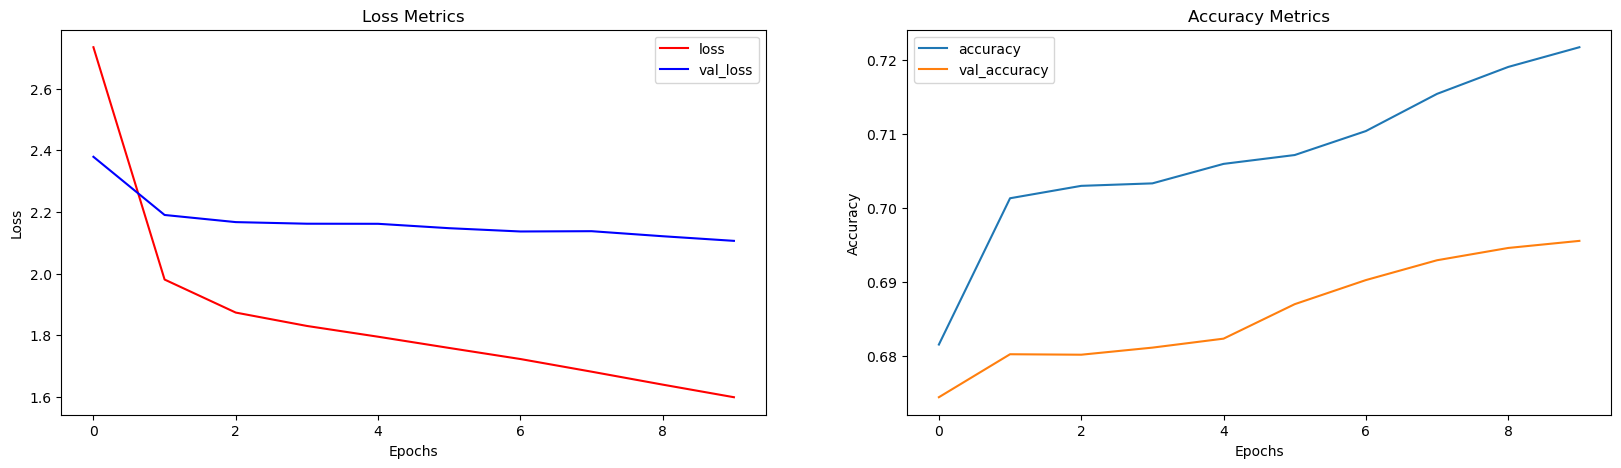

In [45]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

### Save Model

In [46]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [47]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


## Create Inference Model

In [48]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, None, 256)         625408    
 ng)                                                             
                                                                 
 layer_normalization (Layer  (None, None, 256)         512       
 Normalization)                                                  
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1151232 (4.39 MB)
Trainable params: 1

### Time to chat

In [49]:
def print_conversation(texts):
    for text in texts:
        print(f'You: {text}')
        print(f'Bot: {chatbot(text)}')
        print('========================')

In [50]:
print_conversation([
    'hi',
    'do yo know me?',
    'what is your name?',
    'you are bot?',
    'hi, how are you doing?',
    "i'm pretty good. thanks for asking.",
    "Don't ever be in a hurry",
    '''I'm gonna put some dirt in your eye ''',
    '''You're trash ''',
    '''I've read all your research on nano-technology ''',
    '''You want forgiveness? Get religion''',
    '''While you're using the bathroom, i'll order some food.''',
    '''Wow! that's terrible.''',
    '''We'll be here forever.''',
    '''I need something that's reliable.''',
    '''A speeding car ran a red light, killing the girl.''',
    '''Tomorrow we'll have rice and fish for lunch.''',
    '''I like this restaurant because they give you free bread.'''
])

You: hi
Bot: they don't know. 
You: do yo know me?
Bot: no. they said there's the only candidate that i've. 
You: what is your name?
Bot: i'm going to give the sheets. 
You: you are bot?
Bot: i don't know. i'm not sure. 
You: hi, how are you doing?
Bot: i've been working too. 
You: i'm pretty good. thanks for asking.
Bot: no, i think i'll make a sandwich. 
You: Don't ever be in a hurry
Bot: it's a little bitter, but i don't think she's given out that many. 
You: I'm gonna put some dirt in your eye 
Bot: that's a good question. 
You: You're trash 
Bot: i'm sorry. i'm not hungry. 
You: I've read all your research on nano-technology 
Bot: i've been really busy. i love to eat the hot dogs. 
You: You want forgiveness? Get religion
Bot: i'll get a new mattress. 
You: While you're using the bathroom, i'll order some food.
Bot: don't order a good idea. i'll order for your invitation. 
You: Wow! that's terrible.
Bot: never park the car under the tree. 
You: We'll be here forever.
Bot: we'll see